In [1]:
import os
import sys
import numpy as np
import pandas as pd
import itertools
import yaml
import pickle
import multiprocessing
import time 
import matplotlib.pyplot as plt
%matplotlib inline
import ipywidgets as widgets
from collections import OrderedDict

repo_dir = os.path.dirname(os.path.dirname(os.path.abspath("")))
sys.path.append(repo_dir)

from rmg_gua.gua_cantera.Spinning_basket_reactor.sbr import MinSBR

import_julia = True
if import_julia: 
# rms imports
    impt1 = time.time()
    from pyrms import rms
    from diffeqpy import de
    from julia import Main
    from rmg_gua.gua_rms.sbr import rms_sbr
    from rmg_gua.gua_peuqse.peuqse_utilities import get_highest_rms_file
    impt2 = time.time()
    print(f"import of julia packages took {impt2-impt1} seconds")

cantera version:  2.6
import of julia packages took 69.01229500770569 seconds


## 1. load the peuqse optimization results

In [2]:
# # load the results pickle file: 
# with open('./mcmc_map_logP.pkl', 'rb') as f:
#     peuq_map_logp = pickle.load(f)

# with open("./example_peuqse_results.pkl", 'rb') as f:
#     peuq_results = pickle.load(f) 

# # get all results with the same logP (sometimes peuqse has duplicate values)
# match_res_list = []
# for res in peuq_results:
#     if res[0] == peuq_map_logp[0]:
#         match_res_list.append(res)

# match_res_list = np.array(match_res_list)

# # Check that all the results with the same logP are in fact identical
# if not (match_res_list == match_res_list[0]).all():
#     raise Exception("Results with the same logP are not identical!")

# params = match_res_list[0][1:].astype(float).tolist()

gsa_output_dir = os.path.join(repo_dir, "rmg_gua", "gua_peuqse", "gsa_output.pkl")

# load the pickle file
with open(gsa_output_dir, "rb") as f:
    gsa_output = pickle.load(f)

logp = [i[0] for i in gsa_output]
vals = [i[1:] for i in gsa_output]

max_id = np.argmax(logp)
params = vals[max_id][0]


In [3]:
# we need to load the old list of parameters, since we have added more. 

# path = os.path.join(repo_dir, "rmg_gua", "gua_peuqse", "peuqse_runs", "test_run", "config")
path = os.path.join(repo_dir, "rmg_gua", "rmg_model", "config")
with open(os.path.join(path,"rule_config.yaml"), 'r') as f:
    rule_config_unflat = yaml.safe_load(f)

with open(os.path.join(path,"rule_unc_config.yaml"), 'r') as f:
    rule_unc_config_unflat = yaml.safe_load(f)

with open(os.path.join(path,"rule_ub_config.yaml"), 'r') as f:
    rule_ub_unflat = yaml.safe_load(f)

with open(os.path.join(path,"rule_lb_config.yaml"), 'r') as f:
    rule_lb_unflat = yaml.safe_load(f)


# expand rule config and rule uncertainty so it is flat and not nested dict
rule_config = {}
minmax_dict = {}
for key, value in rule_config_unflat.items():
    for k, v in value.items():
        rule_config["_".join([key,k])] = v
        # for the uncertainty, if the value is <0, use ub/lb. else, use +/- unc. 
        if rule_unc_config_unflat[key][k] < 0:
            minmax_dict["_".join([key,k])] = (rule_lb_unflat[key][k],rule_ub_unflat[key][k])
        else: 
            minmax_dict["_".join([key,k])] = (v - rule_unc_config_unflat[key][k], v + rule_unc_config_unflat[key][k])

# open the thermo perturbation config files
with open(os.path.join(path,'be_values.yaml'), 'r') as f:
    be_values = yaml.safe_load(f)

with open(os.path.join(path,"be_unc.yaml"), 'r') as f:    
    be_unc = yaml.safe_load(f)

# be's are going to just be +/- unc
for key, value in be_values.items():
    minmax_dict[key] = (value - be_unc[key], value + be_unc[key])


label_list = list(rule_config.keys()) + list(be_values.keys())
param_dict = dict(zip(label_list, params))





### match up the parameters we are modifying

In [4]:
with open("./config/rule_config.yaml", 'r') as f:
   rule_config_unflat = yaml.safe_load(f)

with open("./config/rule_unc_config.yaml", 'r') as f:
    rule_unc_config_unflat = yaml.safe_load(f)

with open("./config/rule_ub_config.yaml", 'r') as f:
    rule_ub_unflat = yaml.safe_load(f)

with open("./config/rule_lb_config.yaml", 'r') as f:
    rule_lb_unflat = yaml.safe_load(f)


# expand rule config and rule uncertainty so it is flat and not nested dict
rule_config = {}
minmax_dict = {}
for key, value in rule_config_unflat.items():
    for k, v in value.items():
        rule_config["_".join([key,k])] = v
        # for the uncertainty, if the value is <0, use ub/lb. else, use +/- unc. 
        if rule_unc_config_unflat[key][k] < 0:
            minmax_dict["_".join([key,k])] = (rule_lb_unflat[key][k],rule_ub_unflat[key][k])
        else: 
            minmax_dict["_".join([key,k])] = (v - rule_unc_config_unflat[key][k], v + rule_unc_config_unflat[key][k])

# open the thermo perturbation config files
with open('./config/be_values.yaml', 'r') as f:
    be_values = yaml.safe_load(f)

with open("./config/be_unc.yaml", 'r') as f:    
    be_unc = yaml.safe_load(f)

# be's are going to just be +/- unc
for key, value in be_values.items():
    minmax_dict[key] = (value - be_unc[key], value + be_unc[key])


label_list_updated = list(rule_config.keys()) + list(be_values.keys())
param_dict = dict(zip(label_list, params))

if len(param_dict) != len(label_list):
    raise Exception("Param dict and label list are not the same length!")

In [5]:
for label in label_list_updated:
    if label not in label_list:
        param_dict[label] = rule_config[label]
        print("adding {} with value {} since it is in updated model".format(label, param_dict[label]))

for label in label_list:
    if label not in label_list_updated:
        param_dict.pop(label)
        print("removing item {} since it is not in updated config".format(label))

# move the binding energies to the end of the dictionary. the sbr class expects them to be at the end.
updated_param_dict = OrderedDict(param_dict)
for key in be_values.keys():
    updated_param_dict.move_to_end(key)

param_dict = dict(updated_param_dict)

In [6]:
# put in a float slider
widge_list = []
for param, value in param_dict.items():
    widge_list.append(widgets.FloatSlider(
        value=value,
        min=minmax_dict[param][0],
        max=minmax_dict[param][1],
        # step=0.1,
        description=param,
        style = {'description_width': '500px'},
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        layout={'width': '800px'},
        )

    )
for widge in widge_list:
    display(widge)


FloatSlider(value=18.113070918536703, continuous_update=False, description='Surface_Abstraction : O;*C-H_A', l…

FloatSlider(value=137609.71286652345, continuous_update=False, description='Surface_Abstraction : O;*C-H_E0', …

FloatSlider(value=0.6882168845177197, continuous_update=False, description='Surface_Abstraction : O;*C-H_alpha…

FloatSlider(value=18.18475614247067, continuous_update=False, description='Surface_Abstraction_Beta_double_vdW…

FloatSlider(value=80676.76957316059, continuous_update=False, description='Surface_Abstraction_Beta_double_vdW…

FloatSlider(value=0.9106478439025932, continuous_update=False, description='Surface_Abstraction_Beta_double_vd…

FloatSlider(value=17.941806661370894, continuous_update=False, description='Surface_Abstraction_Beta_double_vd…

FloatSlider(value=112732.69220948595, continuous_update=False, description='Surface_Abstraction_Beta_double_vd…

FloatSlider(value=0.8889952114187414, continuous_update=False, description='Surface_Abstraction_Beta_double_vd…

FloatSlider(value=17.47827246302559, continuous_update=False, description='Surface_Abstraction_Beta_double_vdW…

FloatSlider(value=20822.01014200731, continuous_update=False, description='Surface_Abstraction_Beta_double_vdW…

FloatSlider(value=0.022446690674116282, continuous_update=False, description='Surface_Abstraction_Beta_double_…

FloatSlider(value=17.702150600559936, continuous_update=False, description='Surface_Abstraction_Beta_double_vd…

FloatSlider(value=88206.74440262388, continuous_update=False, description='Surface_Abstraction_Beta_double_vdW…

FloatSlider(value=0.7001043400875926, continuous_update=False, description='Surface_Abstraction_Beta_double_vd…

FloatSlider(value=16.486532825627567, continuous_update=False, description='Surface_Abstraction_Beta_double_vd…

FloatSlider(value=111539.96865630374, continuous_update=False, description='Surface_Abstraction_Beta_double_vd…

FloatSlider(value=0.7138826901786495, continuous_update=False, description='Surface_Abstraction_Beta_double_vd…

FloatSlider(value=17.479783976263402, continuous_update=False, description='Surface_Abstraction_Beta_vdW : Abs…

FloatSlider(value=141159.38832864014, continuous_update=False, description='Surface_Abstraction_Beta_vdW : Abs…

FloatSlider(value=0.7792385894535865, continuous_update=False, description='Surface_Abstraction_Beta_vdW : Abs…

FloatSlider(value=16.947859903849004, continuous_update=False, description='Surface_Abstraction_Beta_vdW : O;R…

FloatSlider(value=112901.71117325455, continuous_update=False, description='Surface_Abstraction_Beta_vdW : O;R…

FloatSlider(value=1.1177840563297083, continuous_update=False, description='Surface_Abstraction_Beta_vdW : O;R…

FloatSlider(value=17.463729000650364, continuous_update=False, description='Surface_Abstraction_Beta_vdW : O;R…

FloatSlider(value=25613.849120836552, continuous_update=False, description='Surface_Abstraction_Beta_vdW : O;R…

FloatSlider(value=0.738326329144178, continuous_update=False, description='Surface_Abstraction_Beta_vdW : O;R-…

FloatSlider(value=16.93360589729723, continuous_update=False, description='Surface_Abstraction_Beta_vdW : Abst…

FloatSlider(value=129953.7856636914, continuous_update=False, description='Surface_Abstraction_Beta_vdW : Abst…

FloatSlider(value=1.2050550408591576, continuous_update=False, description='Surface_Abstraction_Beta_vdW : Abs…

FloatSlider(value=17.230178059758973, continuous_update=False, description='Surface_Abstraction_Beta_vdW : O;R…

FloatSlider(value=132467.05858417234, continuous_update=False, description='Surface_Abstraction_Beta_vdW : O;R…

FloatSlider(value=0.7848688304881882, continuous_update=False, description='Surface_Abstraction_Beta_vdW : O;R…

FloatSlider(value=13.130535759109915, continuous_update=False, description='Surface_Abstraction_Single_vdW : D…

FloatSlider(value=331.10347273953175, continuous_update=False, description='Surface_Abstraction_Single_vdW : D…

FloatSlider(value=0.4546305103472121, continuous_update=False, description='Surface_Abstraction_Single_vdW : D…

FloatSlider(value=13.094720350376575, continuous_update=False, description='Surface_Abstraction_Single_vdW : C…

FloatSlider(value=4708.615211792942, continuous_update=False, description='Surface_Abstraction_Single_vdW : C-…

FloatSlider(value=0.4621274356574994, continuous_update=False, description='Surface_Abstraction_Single_vdW : C…

FloatSlider(value=12.013073450456549, continuous_update=False, description='Surface_Abstraction_vdW : Adsorbat…

FloatSlider(value=-5046.220273989236, continuous_update=False, description='Surface_Abstraction_vdW : Adsorbat…

FloatSlider(value=0.2892553173328508, continuous_update=False, description='Surface_Abstraction_vdW : Adsorbat…

FloatSlider(value=13.191093519418274, continuous_update=False, description='Surface_Abstraction_vdW : C-OH;*=C…

FloatSlider(value=20751.19715242264, continuous_update=False, description='Surface_Abstraction_vdW : C-OH;*=C=…

FloatSlider(value=0.7809107032762995, continuous_update=False, description='Surface_Abstraction_vdW : C-OH;*=C…

FloatSlider(value=12.824484117523935, continuous_update=False, description='Surface_Addition_Single_vdW : Adso…

FloatSlider(value=33530.90642392327, continuous_update=False, description='Surface_Addition_Single_vdW : Adsor…

FloatSlider(value=0.16363874560914893, continuous_update=False, description='Surface_Addition_Single_vdW : Ads…

FloatSlider(value=-1.067225581569086, continuous_update=False, description='Surface_Adsorption_Dissociative : …

FloatSlider(value=102856.41955918256, continuous_update=False, description='Surface_Adsorption_Dissociative : …

FloatSlider(value=0.8009208304244082, continuous_update=False, description='Surface_Adsorption_Dissociative : …

FloatSlider(value=-1.202296185179441, continuous_update=False, description='Surface_Adsorption_Dissociative : …

FloatSlider(value=-4551.602472634919, continuous_update=False, description='Surface_Adsorption_Dissociative : …

FloatSlider(value=-0.18672732952503457, continuous_update=False, description='Surface_Adsorption_Dissociative …

FloatSlider(value=-0.3122565814661004, continuous_update=False, description='Surface_Adsorption_Dissociative :…

FloatSlider(value=33588.9230760389, continuous_update=False, description='Surface_Adsorption_Dissociative : CH…

FloatSlider(value=0.2178167924732406, continuous_update=False, description='Surface_Adsorption_Dissociative : …

FloatSlider(value=-1.0135555270383318, continuous_update=False, description='Surface_Adsorption_Dissociative :…

FloatSlider(value=115811.6626020668, continuous_update=False, description='Surface_Adsorption_Dissociative : C…

FloatSlider(value=0.911429410084492, continuous_update=False, description='Surface_Adsorption_Dissociative : C…

FloatSlider(value=-0.4330061575935952, continuous_update=False, description='Surface_Adsorption_Dissociative :…

FloatSlider(value=127630.69333763944, continuous_update=False, description='Surface_Adsorption_Dissociative : …

FloatSlider(value=0.3471064619444346, continuous_update=False, description='Surface_Adsorption_Dissociative : …

FloatSlider(value=-1.1911120241313786, continuous_update=False, description='Surface_Adsorption_Dissociative :…

FloatSlider(value=100791.14042949959, continuous_update=False, description='Surface_Adsorption_Dissociative : …

FloatSlider(value=0.646376247044044, continuous_update=False, description='Surface_Adsorption_Dissociative : C…

FloatSlider(value=-8.032520589890805, continuous_update=False, description='Surface_Adsorption_Dissociative : …

FloatSlider(value=66027.15156766903, continuous_update=False, description='Surface_Adsorption_Dissociative : H…

FloatSlider(value=0.8135458556423565, continuous_update=False, description='Surface_Adsorption_Dissociative : …

FloatSlider(value=-8.079598964998947, continuous_update=False, description='Surface_Adsorption_Dissociative_Do…

FloatSlider(value=135171.73619989664, continuous_update=False, description='Surface_Adsorption_Dissociative_Do…

FloatSlider(value=0.19359120290452292, continuous_update=False, description='Surface_Adsorption_Dissociative_D…

FloatSlider(value=-1.9360284946347992, continuous_update=False, description='Surface_Adsorption_vdW : Adsorbat…

FloatSlider(value=17384.837292847416, continuous_update=False, description='Surface_Adsorption_vdW : Adsorbate…

FloatSlider(value=-0.01943967918699971, continuous_update=False, description='Surface_Adsorption_vdW : Adsorba…

FloatSlider(value=17.005033574776963, continuous_update=False, description='Surface_Dissociation : Combined;Va…

FloatSlider(value=172411.17544688325, continuous_update=False, description='Surface_Dissociation : Combined;Va…

FloatSlider(value=0.9444292379446146, continuous_update=False, description='Surface_Dissociation : Combined;Va…

FloatSlider(value=18.28532998796481, continuous_update=False, description='Surface_Dissociation : C-H;VacantSi…

FloatSlider(value=11286.904997760792, continuous_update=False, description='Surface_Dissociation : C-H;VacantS…

FloatSlider(value=0.5034000531653113, continuous_update=False, description='Surface_Dissociation : C-H;VacantS…

FloatSlider(value=14.570094315279444, continuous_update=False, description='Surface_Dissociation : O-H;VacantS…

FloatSlider(value=160467.37729827253, continuous_update=False, description='Surface_Dissociation : O-H;VacantS…

FloatSlider(value=0.3696787540400648, continuous_update=False, description='Surface_Dissociation : O-H;VacantS…

FloatSlider(value=18.121468895466037, continuous_update=False, description='Surface_Dissociation : C-OH;Vacant…

FloatSlider(value=122017.50647665514, continuous_update=False, description='Surface_Dissociation : C-OH;Vacant…

FloatSlider(value=0.6046941975395782, continuous_update=False, description='Surface_Dissociation : C-OH;Vacant…

FloatSlider(value=12.138079357467394, continuous_update=False, description='Surface_Dissociation_Double_vdW : …

FloatSlider(value=3559.579923393541, continuous_update=False, description='Surface_Dissociation_Double_vdW : A…

FloatSlider(value=0.06742861862708743, continuous_update=False, description='Surface_Dissociation_Double_vdW :…

FloatSlider(value=18.302864836637063, continuous_update=False, description='Surface_Dissociation_vdW : Combine…

FloatSlider(value=162678.41508746674, continuous_update=False, description='Surface_Dissociation_vdW : Combine…

FloatSlider(value=1.0775267274115723, continuous_update=False, description='Surface_Dissociation_vdW : Combine…

FloatSlider(value=16.915160964921306, continuous_update=False, description='Surface_Dissociation_vdW : H2O;Vac…

FloatSlider(value=105202.17444107002, continuous_update=False, description='Surface_Dissociation_vdW : H2O;Vac…

FloatSlider(value=0.6371035776937836, continuous_update=False, description='Surface_Dissociation_vdW : H2O;Vac…

FloatSlider(value=17.3863605375391, continuous_update=False, description='Surface_Dissociation_vdW : C-OH;Vaca…

FloatSlider(value=132190.55395570636, continuous_update=False, description='Surface_Dissociation_vdW : C-OH;Va…

FloatSlider(value=0.5274538963927518, continuous_update=False, description='Surface_Dissociation_vdW : C-OH;Va…

FloatSlider(value=17.96178905240197, continuous_update=False, description='Surface_Dissociation_vdW : C-H;Vaca…

FloatSlider(value=59685.62009808867, continuous_update=False, description='Surface_Dissociation_vdW : C-H;Vaca…

FloatSlider(value=0.27545934198921307, continuous_update=False, description='Surface_Dissociation_vdW : C-H;Va…

FloatSlider(value=17.427656769179336, continuous_update=False, description='Surface_Dissociation_vdW : CH3R;Va…

FloatSlider(value=83380.15722373546, continuous_update=False, description='Surface_Dissociation_vdW : CH3R;Vac…

FloatSlider(value=0.612843318218371, continuous_update=False, description='Surface_Dissociation_vdW : CH3R;Vac…

FloatSlider(value=17.20383710978452, continuous_update=False, description='Surface_Dissociation_vdW : CH2R;Vac…

FloatSlider(value=71423.74072095408, continuous_update=False, description='Surface_Dissociation_vdW : CH2R;Vac…

FloatSlider(value=0.4370433503684647, continuous_update=False, description='Surface_Dissociation_vdW : CH2R;Va…

FloatSlider(value=13.22205054149529, continuous_update=False, description='Surface_Dual_Adsorption_vdW : Adsor…

FloatSlider(value=-3610.327407138501, continuous_update=False, description='Surface_Dual_Adsorption_vdW : Adso…

FloatSlider(value=-0.42733400374990443, continuous_update=False, description='Surface_Dual_Adsorption_vdW : Ad…

FloatSlider(value=-9.550475973074589, continuous_update=False, description='Surface_EleyRideal_Abstraction : A…

FloatSlider(value=69711.30211586709, continuous_update=False, description='Surface_EleyRideal_Abstraction : Ad…

FloatSlider(value=0.31236173191253225, continuous_update=False, description='Surface_EleyRideal_Abstraction : …

FloatSlider(value=-5.941781186288836, continuous_update=False, description='Surface_EleyRideal_Addition_Dual_S…

FloatSlider(value=74921.62010233827, continuous_update=False, description='Surface_EleyRideal_Addition_Dual_Si…

FloatSlider(value=-0.09359531667277106, continuous_update=False, description='Surface_EleyRideal_Addition_Dual…

FloatSlider(value=-3.570369889092521, continuous_update=False, description='Surface_EleyRideal_Addition_Dual_S…

FloatSlider(value=102128.05254343076, continuous_update=False, description='Surface_EleyRideal_Addition_Dual_S…

FloatSlider(value=0.3377108650686433, continuous_update=False, description='Surface_EleyRideal_Addition_Dual_S…

FloatSlider(value=19.932622854505098, continuous_update=False, description='Surface_Migration_Dual_Site : Adso…

FloatSlider(value=179032.78064297553, continuous_update=False, description='Surface_Migration_Dual_Site : Adso…

FloatSlider(value=0.6446357944059702, continuous_update=False, description='Surface_Migration_Dual_Site : Adso…

FloatSlider(value=21394716.84549724, continuous_update=False, description='C', layout=Layout(width='800px'), m…

FloatSlider(value=2930556.658371675, continuous_update=False, description='O', layout=Layout(width='800px'), m…

FloatSlider(value=-802416.5800287782, continuous_update=False, description='N', layout=Layout(width='800px'), …

FloatSlider(value=24707274.83540421, continuous_update=False, description='H', layout=Layout(width='800px'), m…

FloatSlider(value=3582058.0448016664, continuous_update=False, description='vdw', layout=Layout(width='800px')…

## 2. load up a cantera file with the optimized parameters

In [7]:
with open("./config/rule_config.yaml", 'r') as f:
   rule_config_unflat = yaml.safe_load(f)

In [8]:
for key, value in param_dict.items():
    print("{}: {}".format(key, value))

Surface_Abstraction : O;*C-H_A: 18.113070918536703
Surface_Abstraction : O;*C-H_E0: 137609.71286652345
Surface_Abstraction : O;*C-H_alpha: 0.6882168845177197
Surface_Abstraction_Beta_double_vdW : Abstracting;Donating_A: 18.18475614247067
Surface_Abstraction_Beta_double_vdW : Abstracting;Donating_E0: 80676.76957316059
Surface_Abstraction_Beta_double_vdW : Abstracting;Donating_alpha: 0.9106478439025932
Surface_Abstraction_Beta_double_vdW : OH;R-C-H_A: 17.941806661370894
Surface_Abstraction_Beta_double_vdW : OH;R-C-H_E0: 112732.69220948595
Surface_Abstraction_Beta_double_vdW : OH;R-C-H_alpha: 0.8889952114187414
Surface_Abstraction_Beta_double_vdW : OH;R-O-H_A: 17.47827246302559
Surface_Abstraction_Beta_double_vdW : OH;R-O-H_E0: 20822.01014200731
Surface_Abstraction_Beta_double_vdW : OH;R-O-H_alpha: 0.022446690674116282
Surface_Abstraction_Beta_double_vdW : Abstracting;R-CH3_A: 17.702150600559936
Surface_Abstraction_Beta_double_vdW : Abstracting;R-CH3_E0: 88206.74440262388
Surface_Abstract

In [10]:
# load in params from widget
widget = True
if widget:
    for idx, param in enumerate(param_dict.keys()):
        param_dict[param] = widge_list[idx].value
    params = list(param_dict.values())
else: 
    gsa_output_dir = os.path.join(repo_dir, "rmg_gua", "gua_peuqse", "gsa_output.pkl")

    # load the pickle file
    with open(gsa_output_dir, "rb") as f:
        gsa_output = pickle.load(f)

    logp = [i[0] for i in gsa_output]
    vals = [i[1:] for i in gsa_output]

    max_id = np.argmax(logp)
    params = vals[max_id][0]

# load the cantera reactor model: 
project_path = os.path.abspath("")
results_path = os.path.join(project_path, "config")
peuq_path = os.path.join(project_path, "peuqse")

expt_condts = os.path.join(results_path, "expt_data_orig.yaml")
lookup_dict_file = os.path.join(results_path, "rmg_2_ck_dict.yaml")
with open(expt_condts, 'r') as f:
    data = yaml.safe_load(f)

expt = data[0]

file_path = os.path.join(project_path, "cantera", "chem_annotated.yaml")

# load the exp data and lookup dict
with open(expt_condts, 'r') as f:
    data = yaml.load(f, Loader = yaml.FullLoader)
with open(lookup_dict_file, 'r') as f:
    lookup_dict = yaml.load(f, Loader = yaml.FullLoader)

ct_sbr_single = MinSBR(
    file_path,
    reac_config=expt,
    rtol=1.0e-11,
    atol=1.0e-22,
    reaction_list=params, 
    results_path=results_path,
    use_precond=False, 
    time=600,
    save_new_model=True,
    verbose=False,
    )


/Users/blais.ch/Documents/_01_code/05_Project_repos_Github/meOH_repos/uncertainty_analysis/rmg_gua/gua_cantera/Spinning_basket_reactor/sbr.py:122: UserWarning: StickingRate::validate: 
 Sticking coefficient is greater than 1 for reaction 'C(40) + 2 X(1) <=> C[Pt](52) + H*(10)'
 at T = 10000.0

  self.surf = ct.Interface(yaml_file, "surface1", [self.gas])


Cantera version is too old for preconditioning, skipping...


## 3. run one rms reactor with the modified mechanism.
plot the sensitivities and the flux diagram after. 

In [12]:
# if specified, use a different name for the results file. 
output_file_name = "rms_analysis.csv"

use_modified_rms = True
# rmg_model_folder = os.path.join(repo_dir, "rmg_gua", "baseline",)
rmg_model_folder = os.path.join(repo_dir, "rmg_gua", "rmg_model",)
if use_modified_rms: 
    rms_file_path = os.path.join(rmg_model_folder, "rms", "chem_modified.yml")
    output_sens_file = "rms_sensitivities_modified.png" 
    output_flux_file = "rms_fluxes_modified"
else: 
    rms_file_path = get_highest_rms_file(rmg_model_folder)
    output_sens_file = "rms_sensitivities.png"
    output_flux_file = "rms_fluxes"
csv_path = os.path.join(rmg_model_folder, output_file_name)

# generate settings array
settings_yaml =os.path.join(repo_dir, "rmg_gua", "gua_cantera", "experiments_reorg_onlyopt.yaml")
with open(settings_yaml, 'r') as f:
    settings = yaml.safe_load(f)

# initialize reactor
sbr_ss = rms_sbr(
    rms_file_path,
    reac_config = settings[10],
    rtol=1.0e-11,
    atol=1.0e-22,
)

# results = sbr_ss.run_simulation()
# return results
# run the simulation
t1 = time.time()
sbr_ss.sol = de.solve(
    sbr_ss.react.ode,
    de.CVODE_BDF(),
    abstol=sbr_ss.atol,
    reltol=sbr_ss.rtol,)
t2 = time.time()
print("elapsed time for sim: ", t2-t1)


ssys = rms.SystemSimulation(sbr_ss.sol,sbr_ss.domains,sbr_ss.interfaces,sbr_ss.p)

# get the sensitivities. transitory sensitivities returns the full sensitivity matrix
# calculated from the jacobian. returns a (n_species, n_reactions) x (n_species, n_reactions) matrix, 
# so to just get the reaction sensitivities we single out a species for out row, then
# slice out the first n_species columns. 
sens_items, _ = rms.transitorysensitivitiesfulltrapezoidal(ssys.sims[1], 1e-2)#, tau=Main.NaN, normalized=True)
# sens_items, _ = rms.transitorysensitivitiesfullexact(ssys, 0.001)
ind = ssys.names.index("CH3OH")
sens_items_rxn = sens_items[ind,len(ssys.names):]

elapsed time for sim:  14.743274211883545


In [13]:
# sens_items.shape
# for spec in ssys.names:
#     if sens_items[ssys.names.index(spec),0] > 0 or sens_items[ssys.names.index(spec),1] < 0: 
#         print(spec)
#         print(sens_items[ssys.names.index(spec),1])

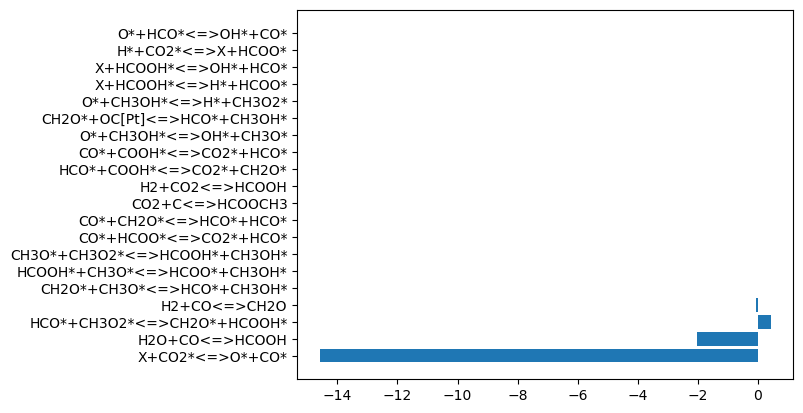

In [14]:
%matplotlib inline
# get list of all rxns
rxn_strs = []
rxns_objs = []
for rxn in ssys.reactions: 
    rxn_strs.append(rms.getrxnstr(rxn))
    rxns_objs.append(rxn)

# I am assuming here that the rxns are in the same order as the sensitivity matrix
rxn_sens_dict = dict(zip(rxn_strs, sens_items_rxn))
# rxn_sens_dict = dict(zip(rxn_strs, sens_items))

# sort the dictionary by value
rxn_sens_dict_sort = dict(sorted(rxn_sens_dict.items(), key=lambda item: abs(item[1])))

# plot the top 10 most sensitive reactions
top10 = list(rxn_sens_dict_sort.items())[-20:]
top10.reverse()
rxn_strs = [x[0] for x in top10]
sens = [x[1] for x in top10]

plt.barh(rxn_strs, sens)
plt.savefig(os.path.join(rmg_model_folder, output_sens_file), dpi=300, bbox_inches='tight')
plt.show()

In [15]:
ssys.sims[1].names

['X',
 'H*',
 'O*',
 'OH*',
 'H2O*',
 'CO*',
 'CO2*',
 'HCO*',
 'HCOO*',
 'COOH*',
 'HCOOH*',
 'CH2O*',
 'CH3O*',
 'CH3O2*',
 'CH3OH*',
 'C[Pt]',
 'OC[Pt]']

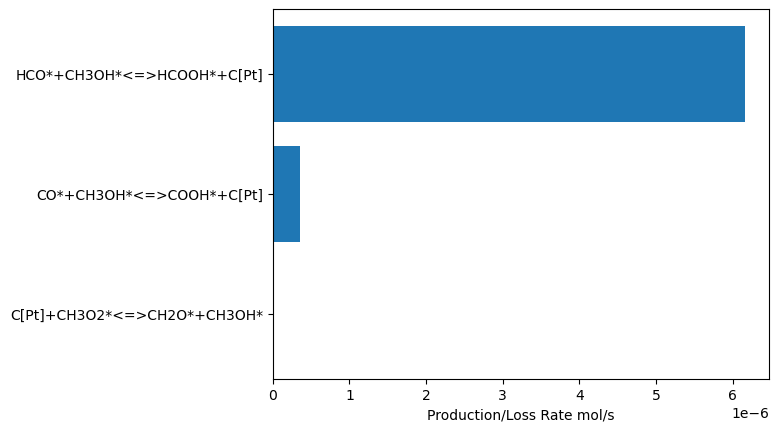

In [17]:
rms.plotrops(ssys.sims[1],"C[Pt]",600)

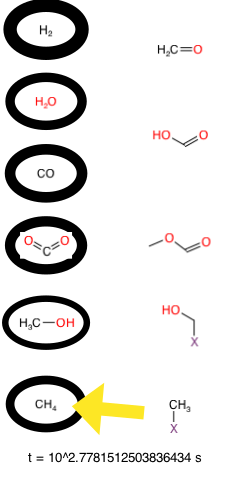

In [364]:
rms.getfluxdiagram(ssys,600, centralspecieslist=['CO', 'CO2', 'CH3OH', 'H2'], radius=5, outputdirectory=output_flux_file)

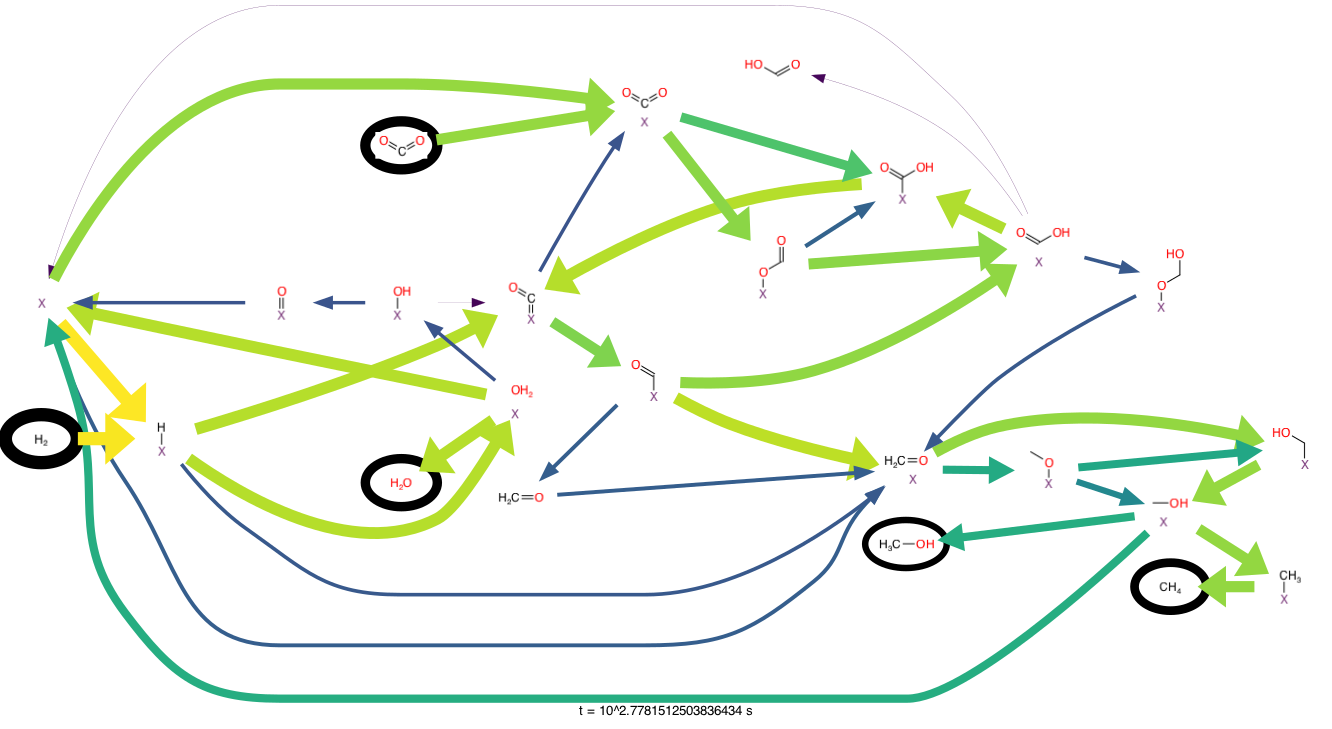

In [365]:
rms.getfluxdiagram(ssys,600,outputdirectory=output_flux_file)

In [19]:
# get list of reactions between ch2ohx and ch3x
from rmgpy.chemkin import load_chemkin_file
from rmgpy.rmg.model import ReactionModel

ck_model_path = os.path.join(rmg_model_folder, "chemkin", "chem_annotated-gas.inp")
species_dict_path = os.path.join(rmg_model_folder, "chemkin",  "species_dictionary.txt")
ck_surface_path = os.path.join(rmg_model_folder, "chemkin",  "chem_annotated-surface.inp")

model = ReactionModel()
model.species, model.reactions = load_chemkin_file(
    path=ck_model_path, 
    dictionary_path=species_dict_path,
    read_comments=True, 
    use_chemkin_names=True,
    surface_path = ck_surface_path,
)

In [22]:
type(model.species)

list

### get reactions that have certain species as reactants or products

C[Pt]


CH3OH*


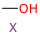

In [23]:
reac_str = "C[Pt]"
prod_str = "CH3OH*"
for idx, spec in enumerate(model.species):
    if spec.label == reac_str: 
         reac_idx = idx
    if spec.label == prod_str:
        prod_idx = idx
    
        

# get reactant of interest
reac1 = model.species[reac_idx]

# get product of interest
prod1 = model.species[prod_idx]
print(reac1.label)
display(reac1)
print(prod1.label)
display(prod1)

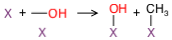

Reverse! Exact match found for rate rule [C-OH;VacantSite]
Euclidian distance = 0
family: Surface_Dissociation_vdW


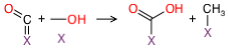

Reverse! Exact match found for rate rule [C-OH;*=C=R]
Euclidian distance = 0
family: Surface_Abstraction_vdW


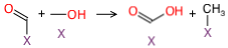

Reverse! Exact match found for rate rule [C-OH;*C=R]
Euclidian distance = 0
family: Surface_Abstraction_Single_vdW
Kinetics were estimated in this direction instead of the reverse because:
This direction matched an entry in Surface_Abstraction_Single_vdW, the other was just an estimate.
dGrxn(298 K) = -14.42 kJ/mol
Ea raised from -5.1 to 0.0 kJ/mol.


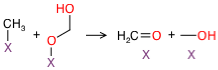

Exact match found for rate rule [Abstracting;Donating]
Euclidian distance = 0
family: Surface_Abstraction_Beta_double_vdW


In [24]:
reac_list = []
for reac in model.reactions:
    if reac1 in reac.reactants and prod1 in reac.products:
    # if prod1 in reac.products:
        reac_list.append(reac)
        display(reac) 
        print(reac.kinetics.comment)
    if reac1 in reac.products and prod1 in reac.reactants:
    # if prod1 in reac.products:
        reac_list.append(reac)
        display(reac) 
        print("Reverse!", reac.kinetics.comment)



In [212]:
# save these reactions to pickle. 
with open("reac_list.pkl", 'wb') as f:
    pickle.dump(reac_list, f)

## 4. use the exported rms model and run for all expt conditions. plot tof on parity plot. 

In [297]:
# run all the reactors in parallel
use_modified_rms = True
rmg_model_folder = os.path.join(repo_dir, "rmg_gua", "rmg_model",)
if use_modified_rms: 
    rms_file_path = os.path.join(rmg_model_folder, "rms", "chem_modified.yml")
    output_file_name = "rms_analysis_modified.csv"
else: 
    rms_file_path = get_highest_rms_file(rmg_model_folder)
    output_file_name = "rms_analysis_original.csv"

csv_path = os.path.join(rmg_model_folder, output_file_name)

# generate settings array
settings_yaml = os.path.join(repo_dir, "rmg_gua", "gua_cantera", "experiments_reorg_onlyopt.yaml")
with open(settings_yaml, 'r') as f:
    settings = yaml.safe_load(f)

def run_reactor(condts):

    # initialize reactor
    sbr_ss = rms_sbr(
        rms_file_path,
        reac_config = condts,
        rtol=1.0e-11,
        atol=1.0e-22,
    )

    results = sbr_ss.run_simulation()
    return results


# Too much memory? is that why it's slow?
# multiprocessing.set_start_method("spawn")
# with multiprocessing.Pool() as p:
#     result = p.map(run_reactor, settings)

result = []
# workaround: just run in serial
count = 0
ttot1 = time.time()
for condition in settings: 
    print("running ", count)
    
    t1 = time.time()
    res = run_reactor(condition)
    result.append(res)
    t2 = time.time()
    
    print(f"process took {t2-t1} seconds")

ttot2 = time.time()
print(f"all reactors took {ttot2-ttot1} seconds")

df = pd.DataFrame(result)

# post process results after pool is finished running
# we will only use runs where intraparticle diffusion limitations
# are not an issue, i.e. T < 518K
df_graaf = df[(df['T (K)'] < 518) & (df['experiment'] == 'graaf_1988') & (df['use_for_opt'] == True)]
df_graaf.to_csv(csv_path)

running  0
elapsed time for sim:  0.17858505249023438
CC  not found in species list
CH4  not found in species list
process took 3.2506520748138428 seconds
running  0
elapsed time for sim:  0.18222975730895996
CC  not found in species list
CH4  not found in species list
process took 3.1938741207122803 seconds
running  0
elapsed time for sim:  0.1899099349975586
CC  not found in species list
CH4  not found in species list
process took 3.3004250526428223 seconds
running  0
elapsed time for sim:  0.1783771514892578
CC  not found in species list
CH4  not found in species list
process took 3.3064701557159424 seconds
running  0
elapsed time for sim:  0.15957903861999512
CC  not found in species list
CH4  not found in species list
process took 3.294015884399414 seconds
running  0
elapsed time for sim:  0.19588899612426758
CC  not found in species list
CH4  not found in species list
process took 3.3409109115600586 seconds
running  0
elapsed time for sim:  0.17742681503295898
CC  not found in sp

In [298]:
df_graaf.columns[:30]

Index(['experiment', 'use_for_opt', 'time (s)', 'T (K)', 'P (Pa)', 'V (m^3/s)',
       'x_CO initial', 'x_CO2 initial', 'x_H2 initial', 'x_H2O initial',
       'CO2/(CO2+CO)', '(CO+CO2/H2)', 'T (K) final', 'Rtol', 'Atol',
       'reactor type', 'energy on?', 'catalyst area', 'graaf MeOH TOF 1/s',
       'graaf H2O TOF 1/s', 'RMG MeOH TOF 1/s', 'RMG H2O TOF 1/s',
       'error squared MeOH TOF', 'error squared H2O TOF', 'obj_func',
       'log10(RMG/graaf) MeOH TOF', 'log10(RMG/graaf) H2O TOF',
       'log10(RMG/graaf) TOF', 'N2', 'Ne'],
      dtype='object')

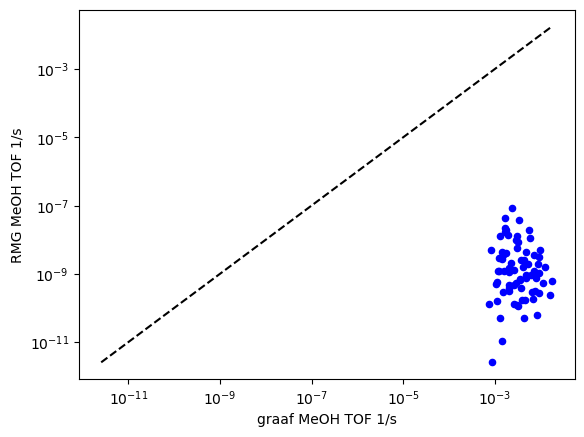

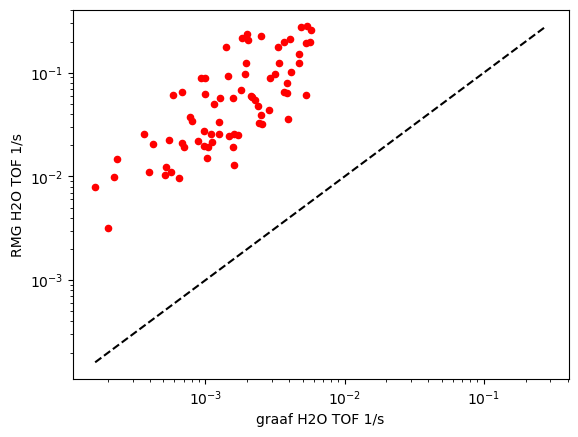

In [299]:
# parity plot of the meoh tof
import numpy as np
csv_path = os.path.join(rmg_model_folder, "rms_analysis_original.csv")
df_graaf = pd.read_csv(csv_path)

meoh_max = max([df_graaf['graaf MeOH TOF 1/s'].max(), df_graaf['RMG MeOH TOF 1/s'].max()])
meoh_min = min([df_graaf['graaf MeOH TOF 1/s'].min(), df_graaf['RMG MeOH TOF 1/s'].min()])
meoh_line = np.logspace(np.log10(meoh_min), np.log10(meoh_max), 10)
plot1 = df_graaf.plot.scatter(x='graaf MeOH TOF 1/s', y='RMG MeOH TOF 1/s', c='blue', loglog=True)
plot1.plot(meoh_line,meoh_line, linestyle='--', c='black', )


# parity plot of the h2o tof
h2o_max = max([df_graaf['graaf H2O TOF 1/s'].max(), df_graaf['RMG H2O TOF 1/s'].max()])
h2o_min = min([df_graaf['graaf H2O TOF 1/s'].min(), df_graaf['RMG H2O TOF 1/s'].min()])
h2o_line = np.logspace(np.log10(h2o_min), np.log10(h2o_max), 10)
plot2 = df_graaf.plot.scatter(x='graaf H2O TOF 1/s', y='RMG H2O TOF 1/s', c='red', loglog=True)
plot2.plot(h2o_line, h2o_line,linestyle='--', c='black', )

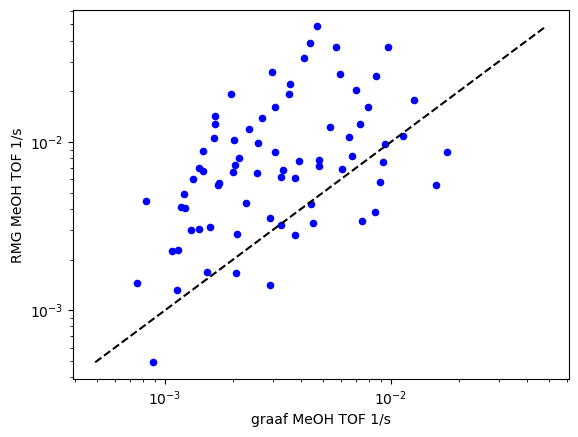

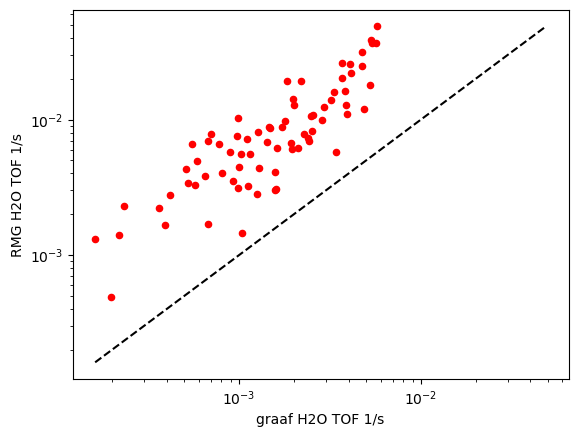

In [300]:
# exact same code as above, except df_graaf is now df_graaf_modified
# parity plot of the meoh tof
csv_path = os.path.join(rmg_model_folder, "rms_analysis_modified.csv")
df_graaf_modified = pd.read_csv(csv_path)

meoh_max = max([df_graaf_modified['graaf MeOH TOF 1/s'].max(), df_graaf_modified['RMG MeOH TOF 1/s'].max()])
meoh_min = min([df_graaf_modified['graaf MeOH TOF 1/s'].min(), df_graaf_modified['RMG MeOH TOF 1/s'].min()])
meoh_line = np.logspace(np.log10(meoh_min), np.log10(meoh_max), 10)
plot1 = df_graaf_modified.plot.scatter(x='graaf MeOH TOF 1/s', y='RMG MeOH TOF 1/s', c='blue', loglog=True)
plot1.plot(meoh_line,meoh_line, linestyle='--', c='black', )

# parity plot of the h2o tof
h2o_max = max([df_graaf_modified['graaf H2O TOF 1/s'].max(), df_graaf_modified['RMG H2O TOF 1/s'].max()])
h2o_min = min([df_graaf_modified['graaf H2O TOF 1/s'].min(), df_graaf_modified['RMG H2O TOF 1/s'].min()])
h2o_line = np.logspace(np.log10(h2o_min), np.log10(h2o_max), 10)
plot2 = df_graaf_modified.plot.scatter(x='graaf H2O TOF 1/s', y='RMG H2O TOF 1/s', c='red', loglog=True)
plot2.plot(h2o_line, h2o_line,linestyle='--', c='black', )

In [ ]:
sens_rxn_obj_dict = {}
top10_dict = dict(top10)
for rxn in rxns_objs: 
    rxn_str = rms.getrxnstr(rxn)
    if rxn_str in top10_dict.keys():#and rxn_str not in sens_rxn_obj_dict.keys():
        sens = abs(rxn_sens_dict[rxn_str])
        print("sens: ", sens, "rxn: ", rxn_str)
        reac_spec = [make_spc(reac) for reac in rxn.reactants]
        prod_spec = [make_spc(prod) for prod in rxn.products]
        sens_rxn_obj_dict[rxn_str] = (sens, reac_spec, prod_spec)
sens_rxn_obj_dict

sens:  6.300549456876386e-14 rxn:  H2+CO<=>CH2O


NameError: name 'make_spc' is not defined

In [ ]:
# now match up the rms reaction sensitivities with the actual rxn in chemkin
# match species does forward and reverse. if there are multiple matches, it will
# print a warning.
match_list = []
sens_cmkn_dict = {}
for rxn_str, entry in sens_rxn_obj_dict.items():
    for rxn in model.reactions:
        counter = 0
        if rxn.matches_species(entry[1],entry[2]):
            print("match : ", rxn_str, counter)
            match_list.append(rxn_str)
            sens_cmkn_dict[rxn_str] = (entry[0], rxn)
        counter += 1
        if counter >=2: 
            print("more than 1 match found for ", rxn_str)
if len(match_list) == len(sens_rxn_obj_dict.keys()):
    print("all matches found")
else: 
    for rxn_str, entry in sens_rxn_obj_dict.items():
        if rxn_str not in match_list:
            print("no match found for ", rxn_str)

# use max key because we have taken abs(sensitivity)
max_key = max(sens_cmkn_dict, key=sens_cmkn_dict.get)
most_sens_rxn = sens_cmkn_dict[max_key][1]

# now pickle the most sensitive reaction
cmkn_pickle_path = os.path.join(rmg_model_folder, "sens_cmkn_dict.pickle")
with open(cmkn_pickle_path, "wb") as f:
    pickle.dump(most_sens_rxn, f)


In [ ]:
most_sens_rxn.get_source()